In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import time

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(42)
pd.set_option('display.max_columns', None)
sns.set_theme(style="darkgrid", font_scale=1.2)

In [21]:
print("Loading the datasets...")

# Path to datasets
train_path = '../resources/train.csv' 
test_path = '../resources/test.csv'
submission_path = '../resources/sample_submission.csv'

# Load datasets
try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    sample_submission = pd.read_csv(submission_path)
    
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Sample submission shape: {sample_submission.shape}")
except FileNotFoundError:
    print("Error: Data files not found. Please adjust the paths to match your file locations.")
    print("You might need to update the paths in this cell to point to where your CSV files are stored.")

Loading the datasets...
Training data shape: (58645, 13)
Test data shape: (39098, 12)
Sample submission shape: (39098, 2)


In [22]:
# Train data overview
print("\n--- Training Data Information ---")
train_data.info()
print("\n--- Summary Statistics ---")
print(train_data.describe())

# Check for missing values
print("\n--- Missing Values in Training Data ---")
print(train_data.isnull().sum())
print("\n--- Missing Values in Test Data ---")
print(test_data.isnull().sum())

# Check the target variable distribution
print("\n--- Target Variable Distribution ---")
print(train_data['loan_status'].value_counts(normalize=True))


--- Training Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
d

                 id    person_age  person_income  person_emp_length  \
count  58645.000000  58645.000000   5.864500e+04       58645.000000   
mean   29322.000000     27.550857   6.404617e+04           4.701015   
std    16929.497605      6.033216   3.793111e+04           3.959784   
min        0.000000     20.000000   4.200000e+03           0.000000   
25%    14661.000000     23.000000   4.200000e+04           2.000000   
50%    29322.000000     26.000000   5.800000e+04           4.000000   
75%    43983.000000     30.000000   7.560000e+04           7.000000   
max    58644.000000    123.000000   1.900000e+06         123.000000   

          loan_amnt  loan_int_rate  loan_percent_income  \
count  58645.000000   58645.000000         58645.000000   
mean    9217.556518      10.677874             0.159238   
std     5563.807384       3.034697             0.091692   
min      500.000000       5.420000             0.000000   
25%     5000.000000       7.880000             0.090000   
50%   

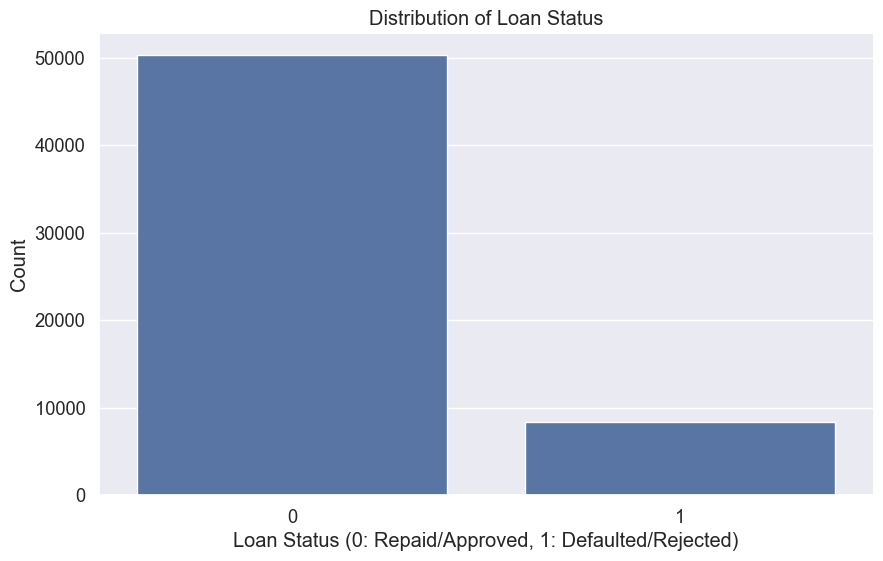

In [23]:
# Show Loan Status Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=train_data)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status (0: Repaid/Approved, 1: Defaulted/Rejected)')
plt.ylabel('Count')
plt.show()

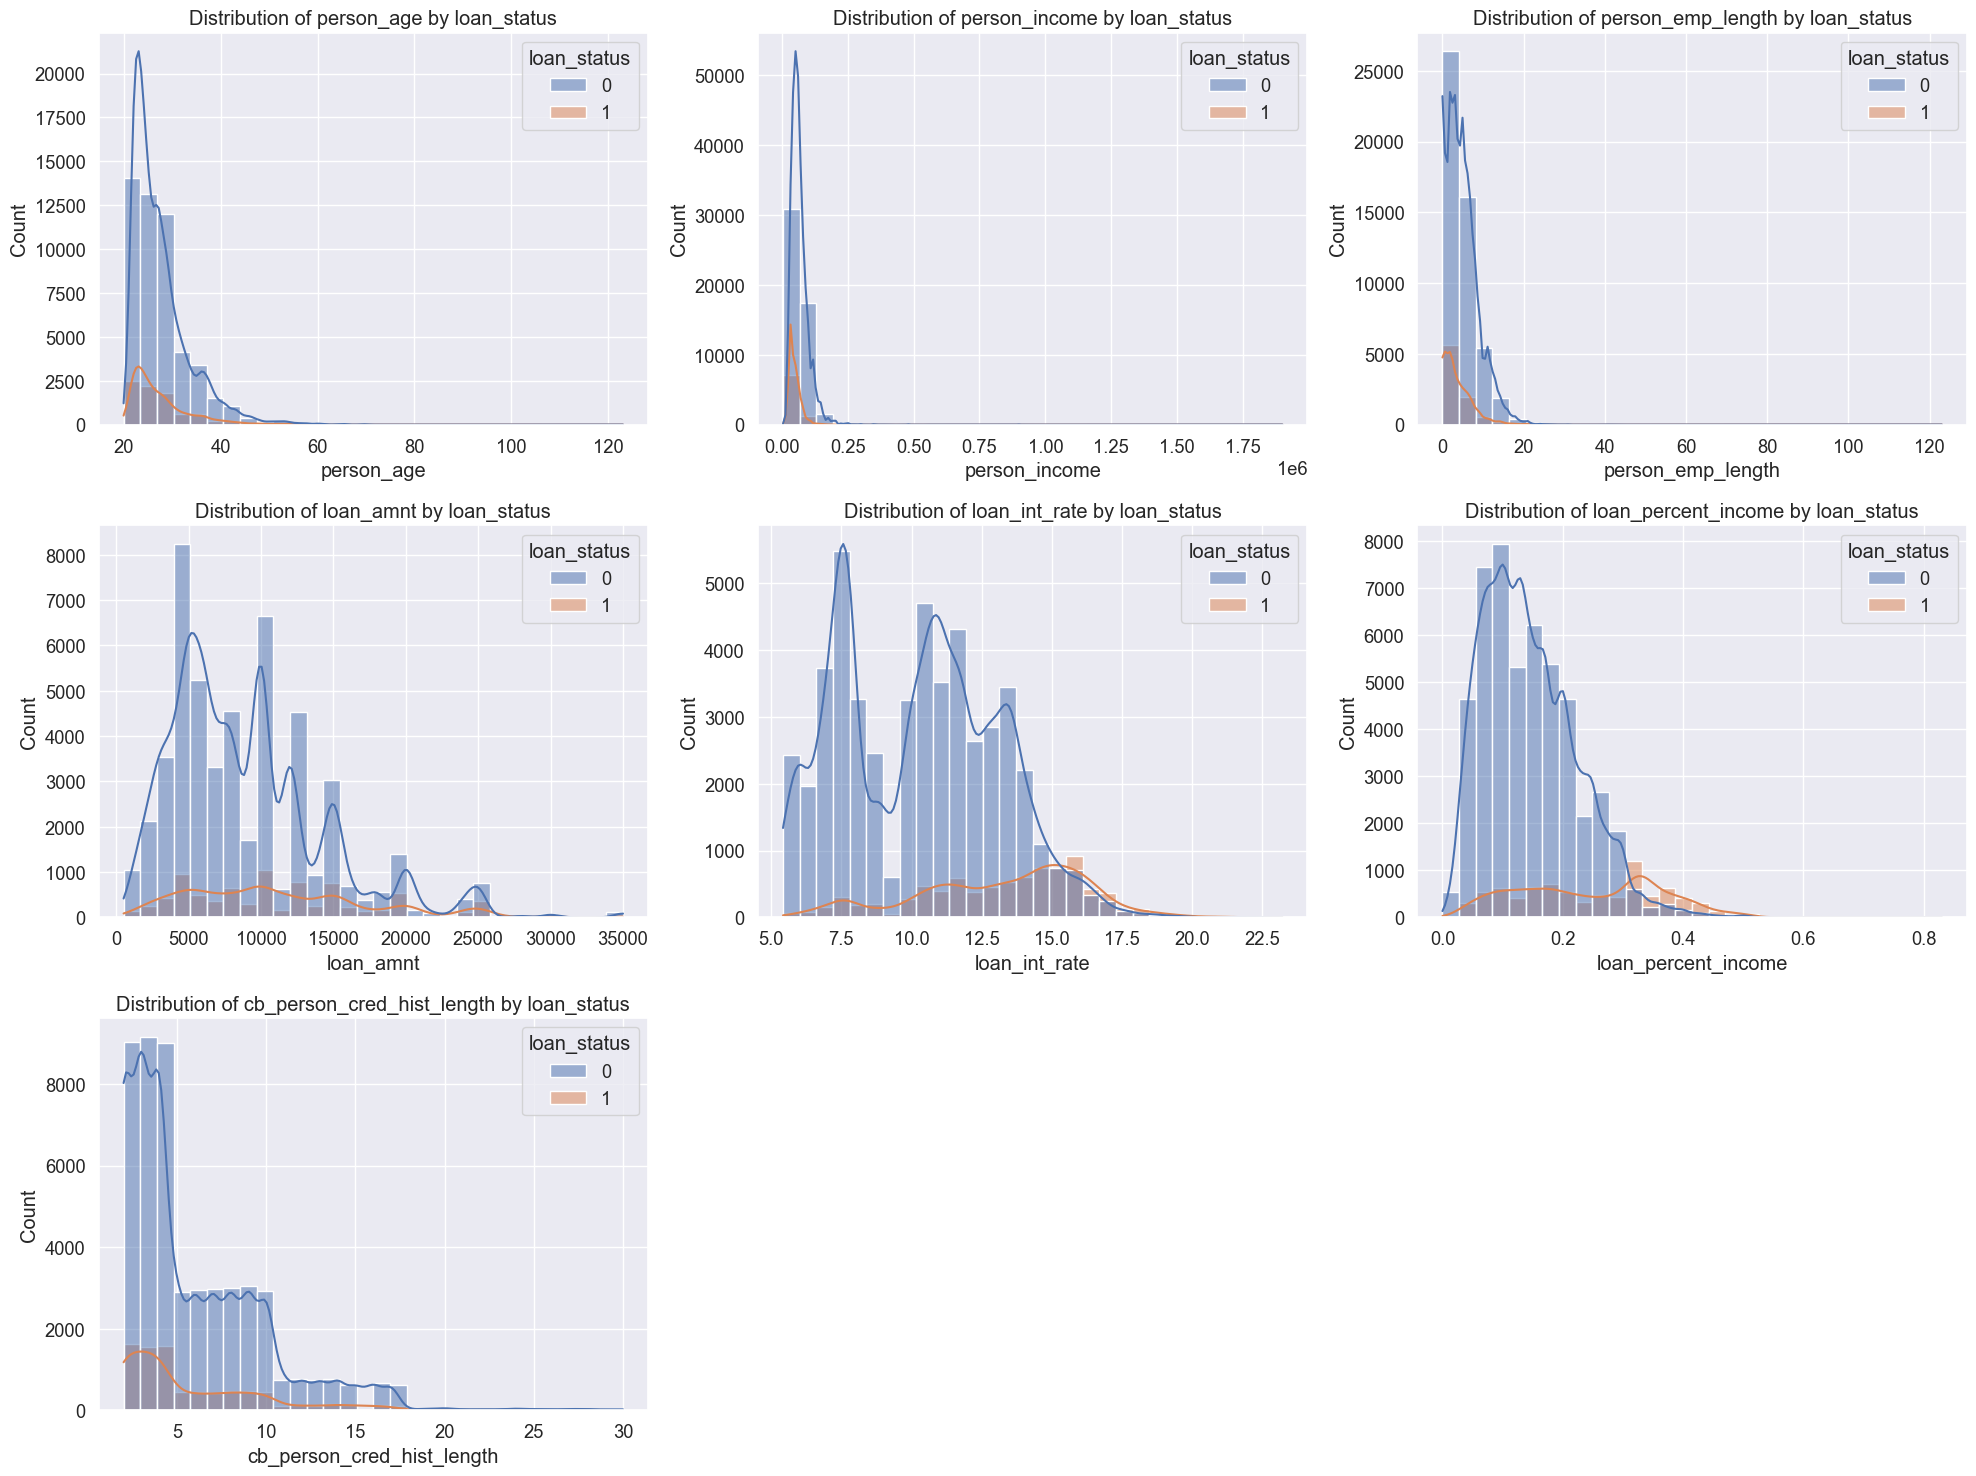

In [24]:
# Show Graphs Distribution of Numerical Features
numerical_features = ['person_age', 'person_income', 'person_emp_length', 
                     'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                     'cb_person_cred_hist_length']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=train_data, x=feature, hue='loan_status', bins=30, kde=True)
    plt.title(f'Distribution of {feature} by loan_status')
plt.tight_layout()
plt.show()

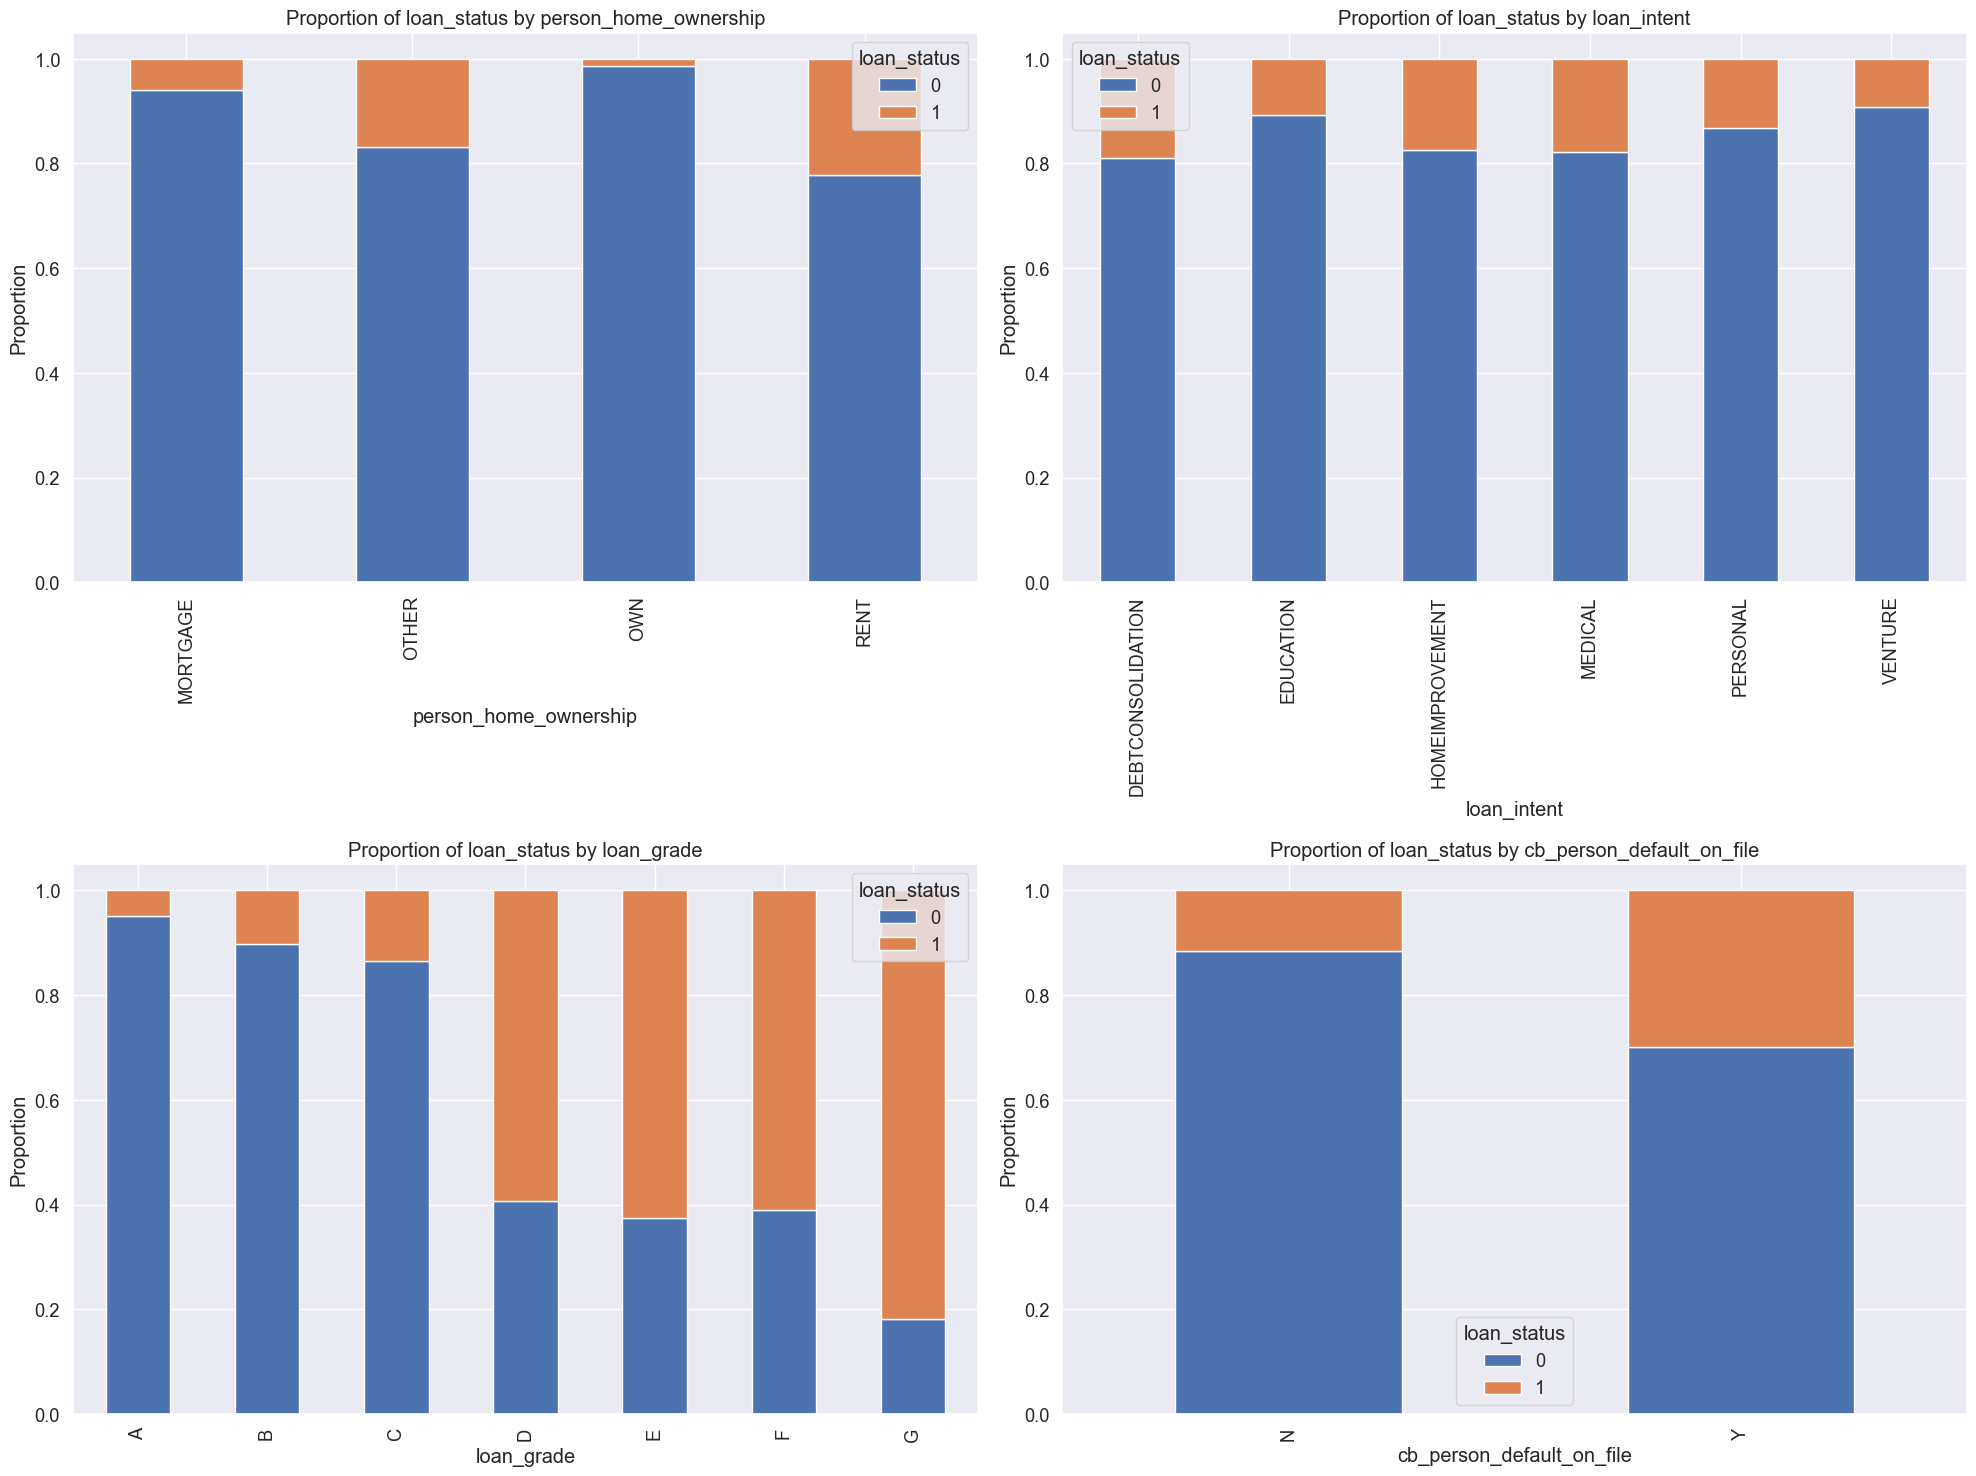

In [25]:
# Show Graphs Distribution of Categorical Features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

fig, axs = plt.subplots(2, 2, figsize=(20, 15))  
axs = axs.flatten() 

for i, feature in enumerate(categorical_features):
    ct = pd.crosstab(train_data[feature], train_data['loan_status'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axs[i])
    axs[i].set_title(f'Proportion of loan_status by {feature}')
    axs[i].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

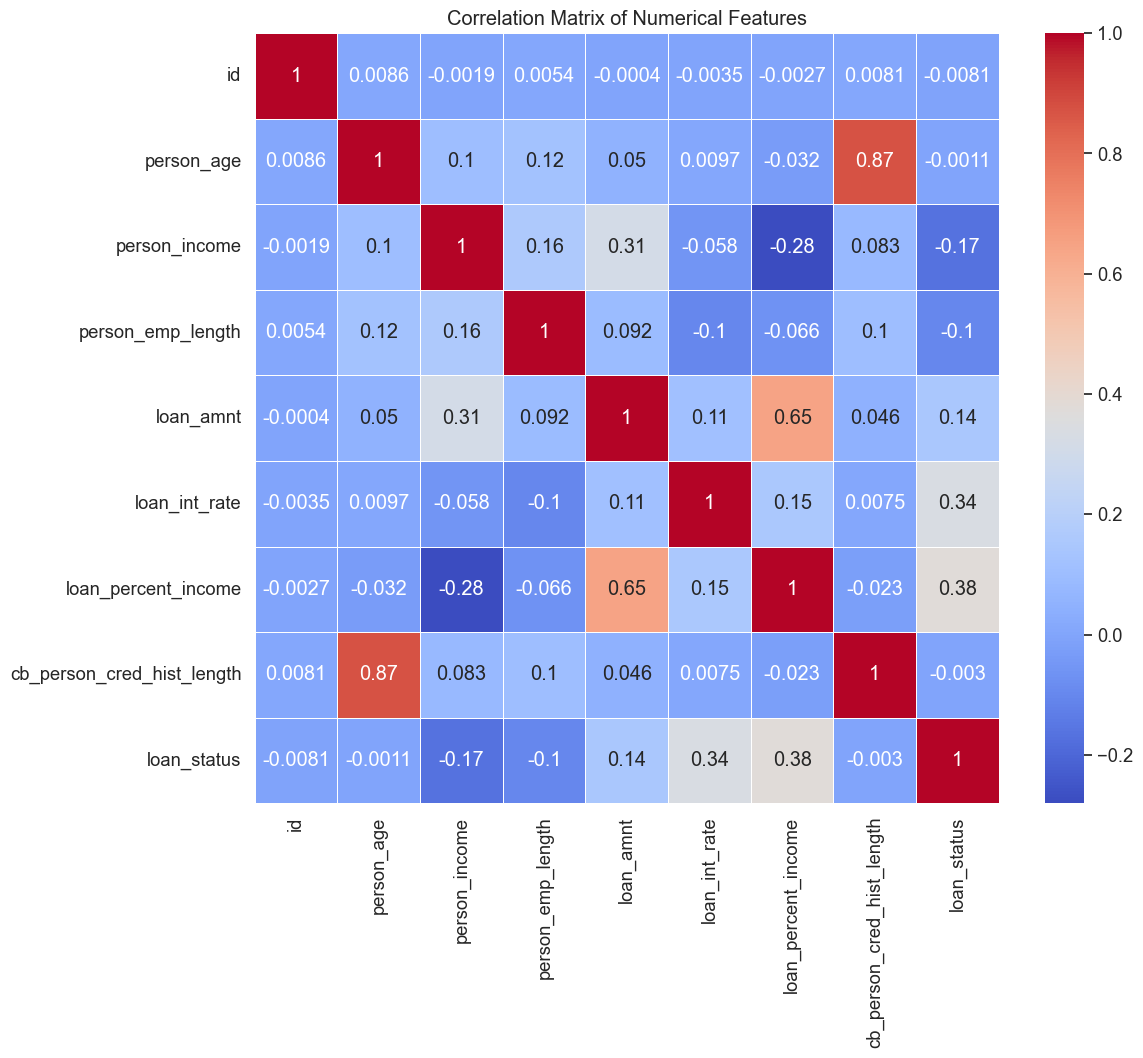

In [26]:
# Show correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = train_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [27]:
# Separate features and target variable
X_train = train_data.drop(['loan_status', 'id'], axis=1)
y_train = train_data['loan_status']
X_test = test_data.drop(['id'], axis=1)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print("\nNumerical features:", numerical_features)
print("Categorical features:", categorical_features)


# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


Numerical features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical features: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [28]:
# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Training 
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Testing 
    start_time = time.time()
    y_pred = model.predict(X_val)
    test_time = time.time() - start_time

    # Calculate metrics and confusion matrix
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    # Check if the model supports predict_proba for ROC AUC
    try:
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)
        has_roc = True
    except:
        has_roc = False
        roc_auc = None
        fpr, tpr = None, None

    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if has_roc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Training time: {train_time:.4f} seconds")
    print(f"Testing time: {test_time:.4f} seconds")
    # ----------------------------------------------------------------- #

    # Print graphical representation of the results for each model
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['0', '1'], 
                yticklabels=['0', '1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve if available
    if has_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=3,       # ideal cv=5
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='f1', n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                        alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, label='Validation score', color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                        alpha=0.1, color='red')
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Return metrics for further analysis
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'test_time': test_time
    }


Training Random Forest...

--- Random Forest Results ---
Accuracy: 0.9507
Precision: 0.9292
Recall: 0.7078
F1 Score: 0.8035
ROC AUC: 0.9308
Training time: 7.3993 seconds
Testing time: 0.2457 seconds


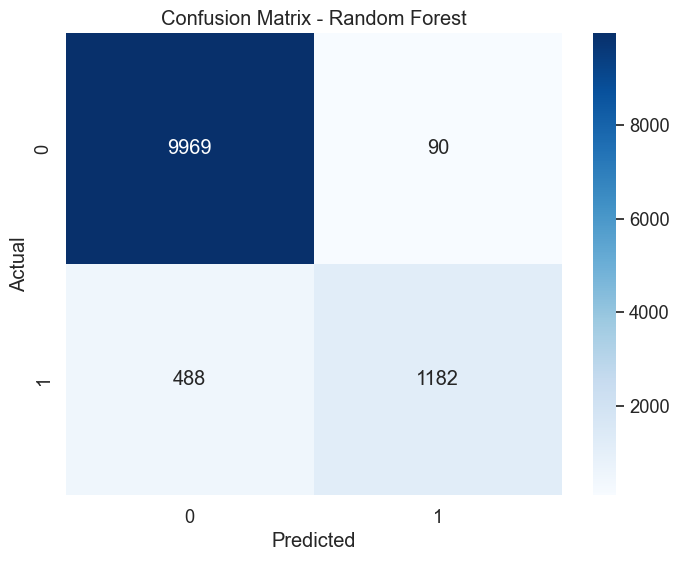

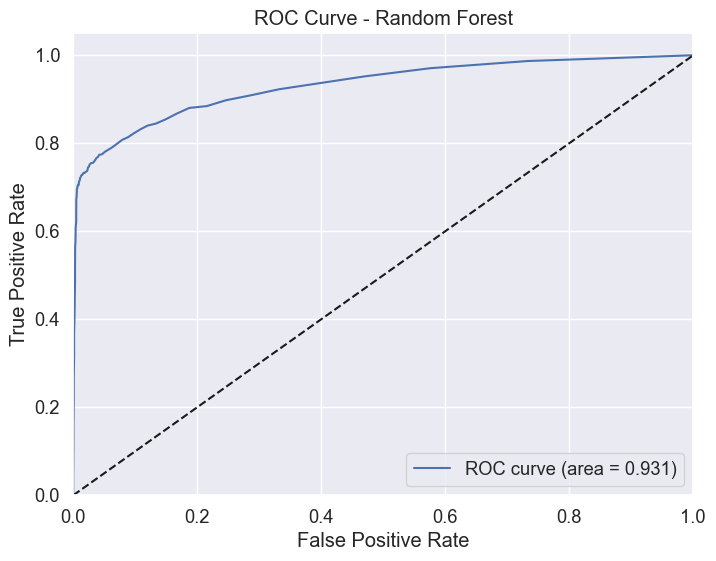

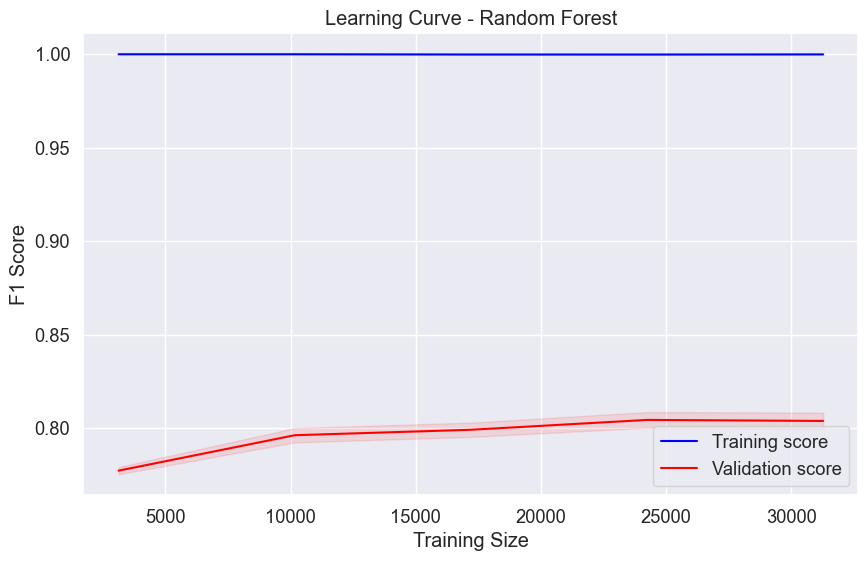

In [29]:
# Models to evaluate
models = {
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

# Train and evaluate all models
results = []
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    result = evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name)
    results.append(result)

In [30]:
# Show and compare model performances
results_df = pd.DataFrame(results)
print("\n--- Model Comparison ---")
print(results_df[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'train_time', 'test_time']])


--- Model Comparison ---
      model_name  accuracy  precision    recall        f1   roc_auc  \
0  Random Forest   0.95072   0.929245  0.707784  0.803535  0.930816   

   train_time  test_time  
0     7.39932   0.245727  


<Figure size 1200x800 with 0 Axes>

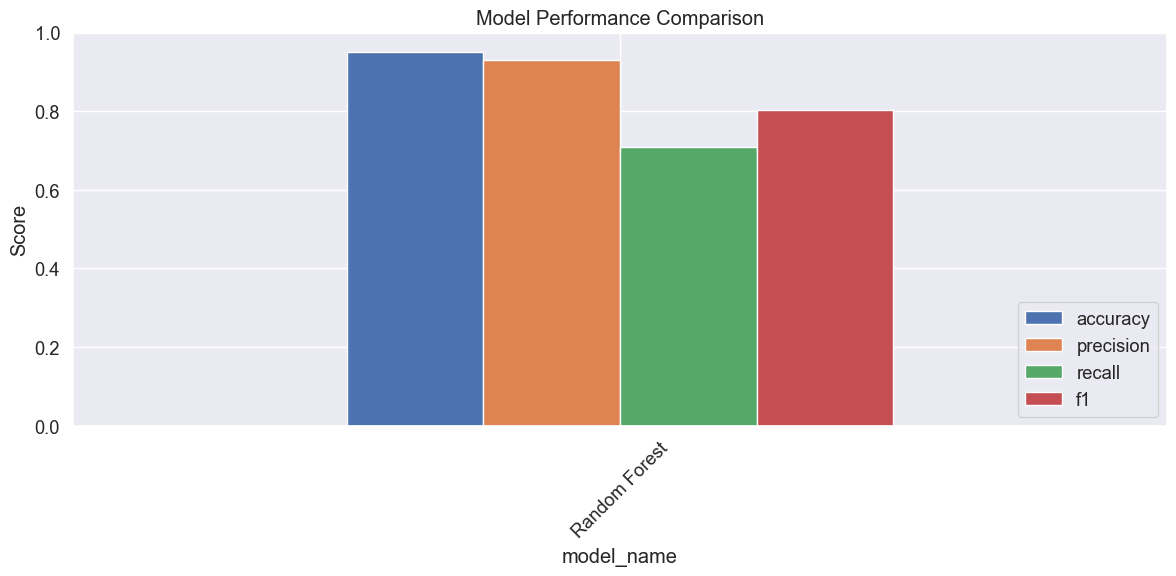

In [31]:
# Show model performance comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
plt.figure(figsize=(12, 8))
results_plot = results_df.set_index('model_name')[metrics]
results_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

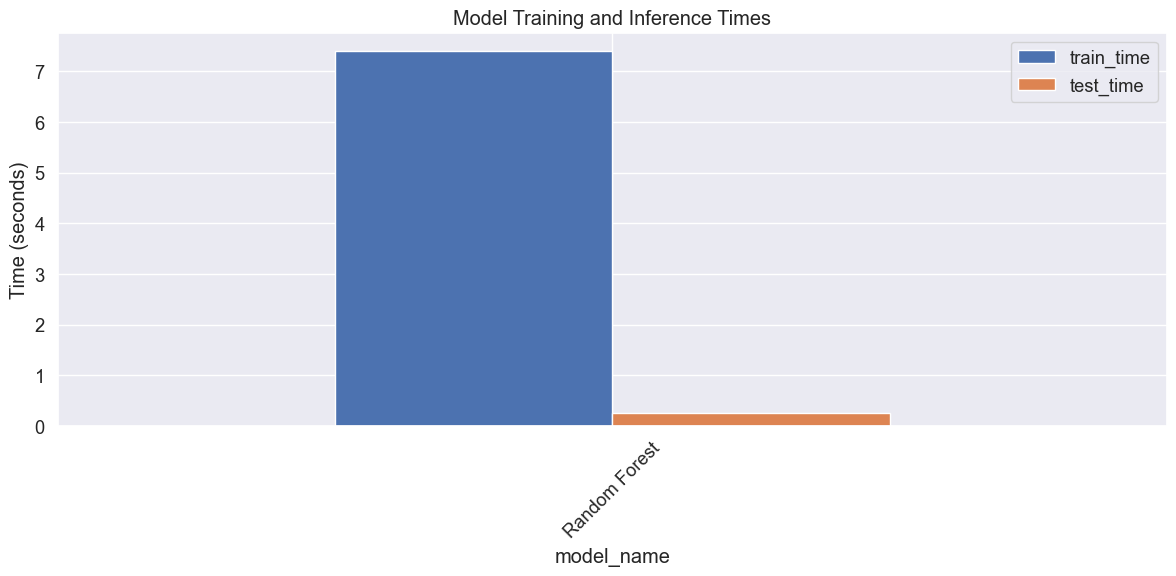

In [32]:
# Show Training and inference times
plt.figure(figsize=(12, 6))
times_df = results_df.set_index('model_name')[['train_time', 'test_time']]
times_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Training and Inference Times')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [64]:
# Identify the best model based on F1 score
best_model_name = results_df.loc[results_df['f1'].idxmax(), 'model_name']
print(f"\nBest performing model: {best_model_name}")

# Define parameter grid for the best model
if best_model_name == 'Decision Tree':
    param_grid = {
         'classifier__max_depth': [5, 10, 15, 20, None],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [10, 15, 20, 25, 30],
        'classifier__min_samples_split': [2, 4],
        'classifier__min_samples_leaf': [1, 2]
    }
elif best_model_name == 'Neural Network':
    param_grid = {
         'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
         'classifier__alpha': [0.0001, 0.001, 0.01],
         'classifier__learning_rate': ['constant', 'adaptive']
    }
elif best_model_name == 'SVM':
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto', 0.1, 1]
    }
elif best_model_name == 'K-Nearest Neighbors':
    param_grid = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }

# Perform grid search
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
grid_search = GridSearchCV(
    models[best_model_name],
    param_grid,
    cv=5,       # ideal cv=5
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best performing model: Random Forest

Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Best parameters: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 50}
Best cross-validation score: 0.8074



--- Tuned Random Forest Results ---
Accuracy: 0.9510
Precision: 0.9294
Recall: 0.7096
F1 Score: 0.8048
ROC AUC: 0.9269
Training time: 3.4851 seconds
Testing time: 0.1343 seconds


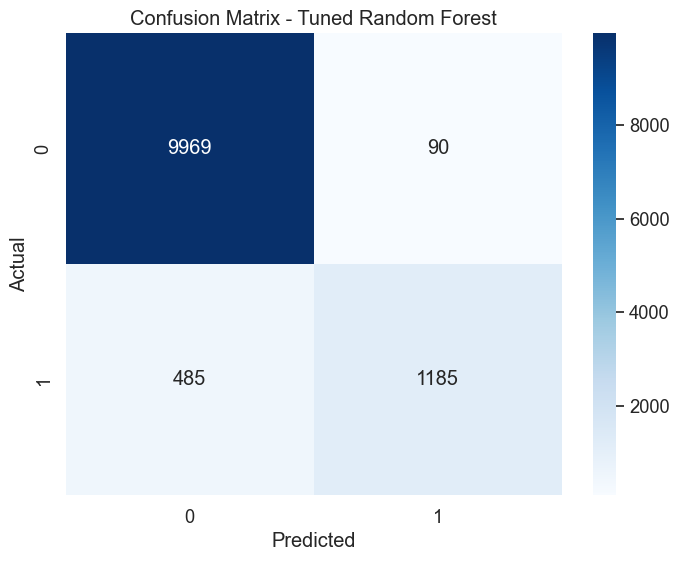

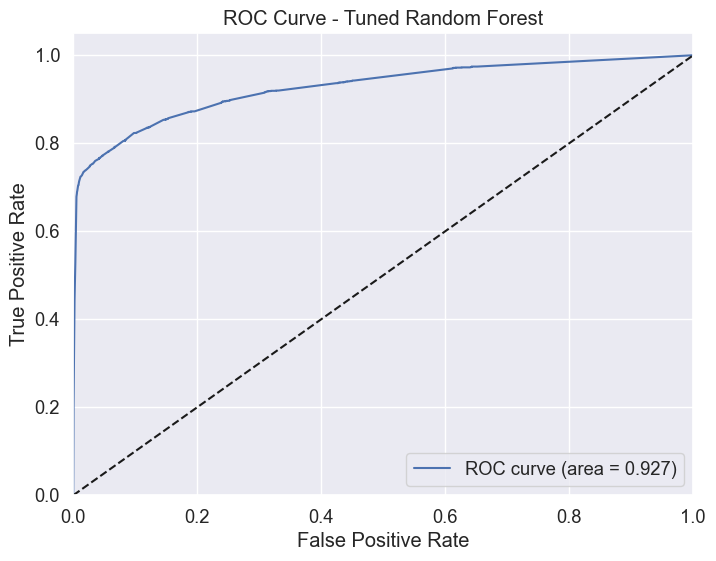

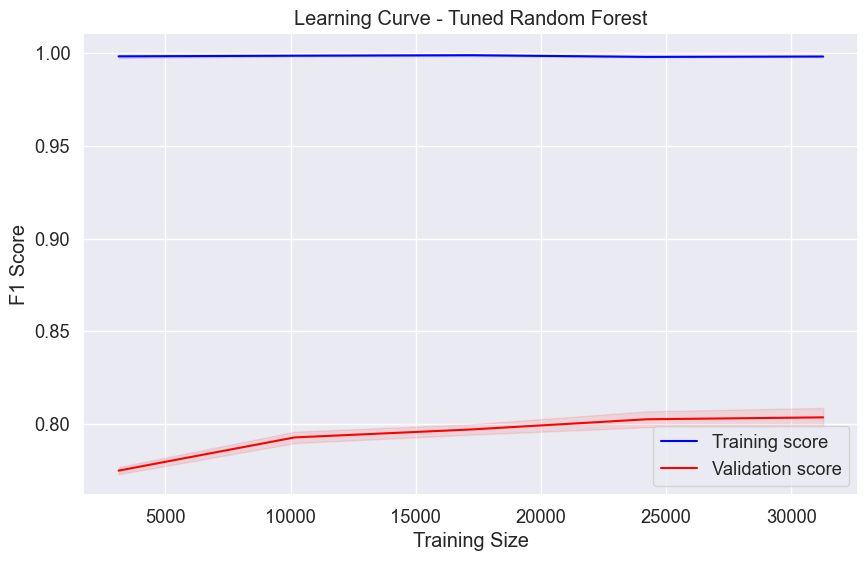

In [63]:
# Evaluate the tuned model and plot results
best_model = grid_search.best_estimator_
result = evaluate_model(best_model, X_train_split, y_train_split, X_val, y_val, f"Tuned {best_model_name}")

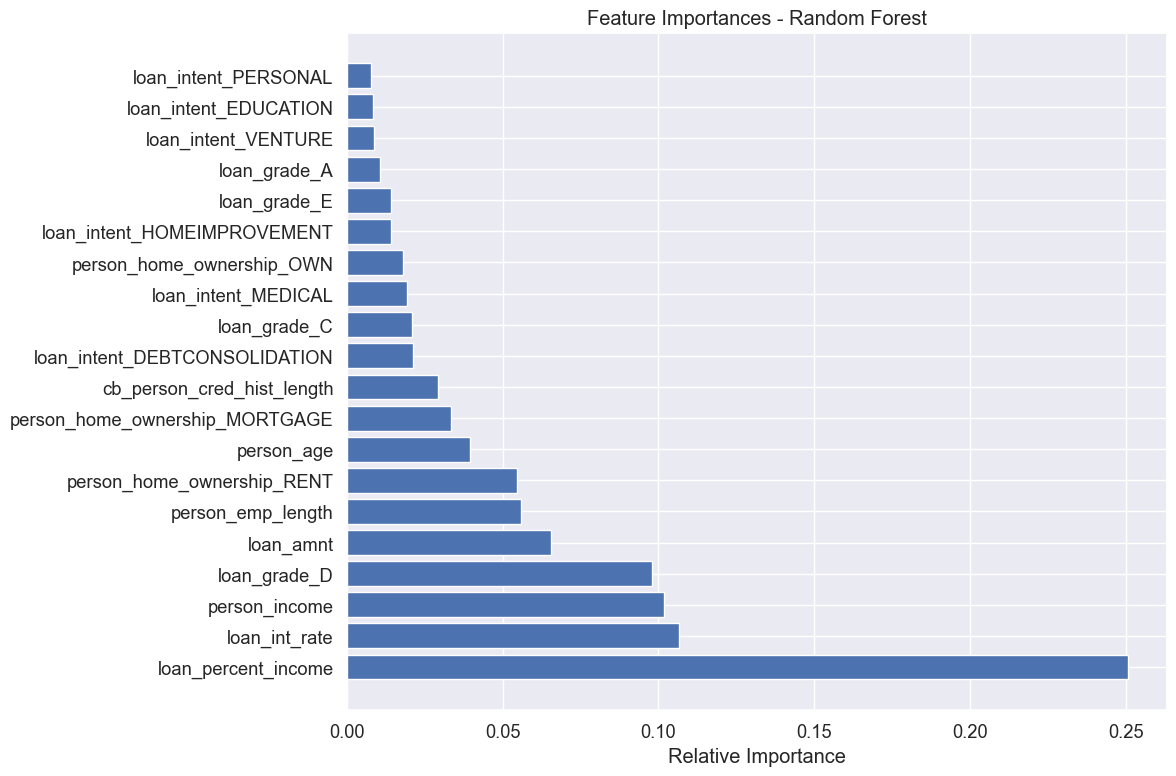

In [58]:
# Show feature importances
if best_model_name in ['Decision Tree', 'Random Forest']:
    preprocessor = best_model.named_steps['preprocessor']  
    classifier = best_model.named_steps['classifier']   

    # Fit the preprocessor on the training data
    preprocessor.fit(X_train)
    
    # Transform the training data to obtain feature names and importances
    cat_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numerical_features, cat_features])
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Feature Importances - {best_model_name}")
    plt.barh(range(min(20, len(indices))), importances[indices[:20]], align='center')
    plt.yticks(range(min(20, len(indices))), [feature_names[i] for i in indices[:20]])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

In [43]:
# Train the best model 
print("\nTraining the best model on the entire training set...")
best_model.fit(X_train, y_train)

# Generate predictions
print("Generating predictions for the test set...")
test_predictions = best_model.predict(X_test)

# Create submission file 
submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_status': test_predictions
})

# Save submission file
submission.to_csv('../resources/loan_approval_submission.csv', index=False)
print("Submission file created: loan_approval_submission.csv")


Training the best model on the entire training set...
Generating predictions for the test set...
Submission file created: loan_approval_submission.csv



--- Final Summary ---
Best model: Random Forest
After tuning, F1 score improved from 0.8035 to 0.8072

Class distribution in test predictions:
0    0.893805
1    0.106195
Name: proportion, dtype: float64


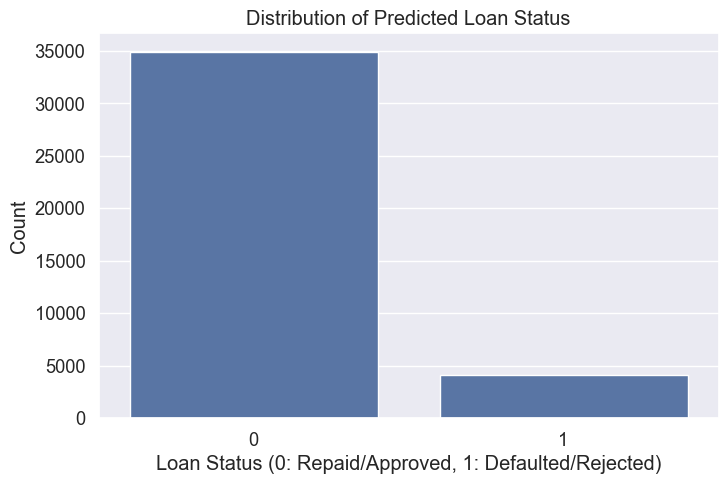


Analysis Complete!


In [59]:
# Final summary
print("\n--- Final Summary ---")
print(f"Best model: {best_model_name}")
if best_model_name != f"Tuned {best_model_name}":
    print(f"After tuning, F1 score improved from {results_df.loc[results_df['model_name'] == best_model_name, 'f1'].values[0]:.4f} to {result['f1']:.4f}")

# Display class distribution in predictions
print("\nClass distribution in test predictions:")
print(pd.Series(test_predictions).value_counts(normalize=True))

# Show the final distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=test_predictions)
plt.title('Distribution of Predicted Loan Status')
plt.xlabel('Loan Status (0: Repaid/Approved, 1: Defaulted/Rejected)')
plt.ylabel('Count')
plt.show()

print("\nAnalysis Complete!")